<a href="https://colab.research.google.com/github/therahulmehta/MNIST_classification/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
# view the keys for 70,000 images with 784 features
# 28 x 28 px
# pixel intensity from 0 to 255
X, y = mnist["data"], mnist["target"]
X.shape
y.shape

(70000,)

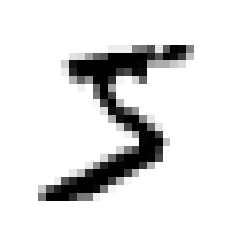

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap ="binary")
plt.axis("off")
plt.show()

In [4]:
import numpy as np
# cast data to int
y = y.astype(np.uint8)

# split train and test (data already shuffled)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
# training binary classifier -- split data
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [6]:
# training binary classifier -- load model (linear)
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

#startified sampling
skflods = StratifiedKFold(n_splits=3, random_state=42)

#similar to cross_val_score()
for train_index, test_index in skflods.split(X_train, y_train_5): 
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [8]:
# verify custom validator is working 
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [9]:
# data is already skewed, lets try a confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

#cross_val_predict() performs k-fold validation but returns predictions made on each test fold 
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [10]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [11]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [12]:
# F1 score is the harmonic mean of the precision and recall
# F1 favous classifers taht have similar precision and recall from the confusion matrix 
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [13]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [14]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [15]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [16]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [17]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [18]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()

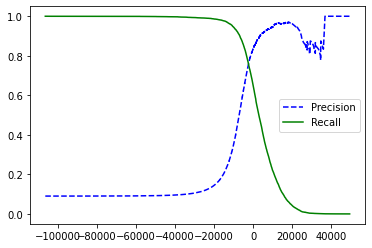

In [19]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [20]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [21]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [22]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [23]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [24]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

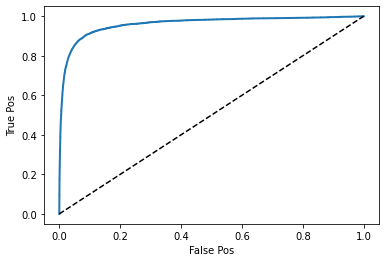

In [25]:
def plot_roc_curve(fpr, tpr, axlabel, aylabel, itemlabel): 
    plt.plot(fpr, tpr, linewidth=2, label=itemlabel)
    plt.plot([0,1], [0,1], 'k--') #dashed diagonal line
    plt.xlabel(axlabel)
    plt.ylabel(aylabel)

plot_roc_curve(fpr,tpr, "False Pos", "True Pos", "")
plt.show()

In [26]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

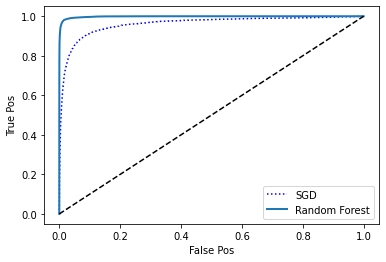

0.9983436731328145

In [28]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr,tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "False Pos", "True Pos",  "Random Forest")
plt.legend(loc="lower right")
plt.show()

roc_auc_score(y_train_5, y_scores_forest)

<h3> Multiclass <h3>

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

In [ ]:
np.argmax(some_digit_scores)
svm_clf.classes_

In [ ]:
svm_clf.classes_[5]

<h5> OvR; SGD Classifiers <h5>

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

#sdg classifers directly classify instances into mulitple classes


In [ ]:
sgd_clf.decision_function([some_digit])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
# all accuracies above 80%

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

<h5> Error Analysis <h5>

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx